## SDF Library

In [1]:
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import jax
import matplotlib.pyplot as plt

In [108]:
def _length(a):
    return jnp.linalg.norm(a, axis=1)

ORIGIN = jnp.array((0, 0))

SEED = jax.random.PRNGKey(0)


def circle(radius=1, center=(0, 0)):
    center = jnp.array(center)
    def f(p):
        return _length(p - center) - radius

    return f

def translate(sdf, offset):
    offset = jnp.array(offset)
    def f(p):
        return sdf(p - offset)

    return f


def rotate(sdf, angle):
    s = jnp.sin(angle)
    c = jnp.cos(angle)
    m = 1 - c
    matrix = jnp.array(
        [
            [c, -s],
            [s, c],
        ]
    ).T

    def f(p):
        return sdf(jnp.dot(p, matrix))

    return f

def rotate_around_center(sdf, angle, center):
    center = jnp.array(center)

    def f(p):
        v = translate(rotate(translate(sdf, -center), angle), center)(p)
        return v

    return f

def rectangle(size=1, center=(0, 0)):
    center = jnp.array(center)
    size = jnp.array(size)

    def f(p):
        q = jnp.abs(p - center) - size / 2
        return _length(jnp.maximum(q, 0)) + jnp.minimum(jnp.amax(q, axis=1), 0)

    return f

def bottom_half_plane(p):
    return p[:, 1]

def intersection(sdf1, sdf2):
    def f(p):
        return jnp.maximum(sdf1(p), sdf2(p))
    return f
    


In [3]:
def show_sdf(sdf, bounds=(-1, 1), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    plt.imshow(1-inside(sdf)(grid_points).reshape(n, n), cmap="gray", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

In [4]:
N = 1000
shape = (N, 2)
dtype = jnp.float32

def naive_area(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    computed_sdf = sdf(random_numbers) < 0
    return jnp.sum(computed_sdf) / n * (bounds[1] - bounds[0])**2

In [5]:
def inside(sdf):
   def f(p):
       distance = sdf(p)
       return 1-jax.nn.sigmoid(100* distance)

   return f

In [6]:
def area(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    computed_sdf = inside(sdf)(points)
    return jnp.sum(computed_sdf) / n * (bounds[1] - bounds[0])**2
    

In [9]:
def centroid(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    inside_points = inside(sdf)(points)
    return jnp.average(points, weights=inside_points, axis=0)

## The boat problem

In [219]:
RELATIVE_DENSITY = 0.5
SAMPLE_SIZE = 10000
INTEGRATION_BOUNDS = (-3, 3)

In [220]:
def update_position(original_shape, original_shape_center, p1, p2):
    return translate(rotate_around_center(original_shape, p1, original_shape_center), (0, p2))

def alignment_cost(shape):
    shape_center_of_gravity = centroid(shape, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)
    shape_area = area(shape, bounds=(-5, 5), n=SAMPLE_SIZE)

    shape_weight = shape_area * RELATIVE_DENSITY

    displacement = intersection(bottom_half_plane, shape)
    buoyancy_center = centroid(displacement, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)

    displacement_weight = area(displacement, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)

    gravity_cost = displacement_weight - shape_weight
    torque_cost = (buoyancy_center - shape_center_of_gravity)[0]

    return jnp.linalg.norm(jnp.array([gravity_cost, torque_cost]))

### Solving the equilibrium of a circle

In [221]:
shape = (
    circle(1, (0, -0.5)),
    (0, -0.5)
)

def cost(x, y):
    return alignment_cost(update_position(shape[0], shape[1], x, y))
jax.value_and_grad(cost, (0, 1))(jnp.array(0.0), jnp.array(0.0))

(Array(0.89770174, dtype=float32),
 (Array(-4.0017767e-11, dtype=float32, weak_type=True),
  Array(-2.035065, dtype=float32, weak_type=True)))

iterations 5
end position change [-3.8916346e-09  4.9925917e-01]
final cost 0.008331229


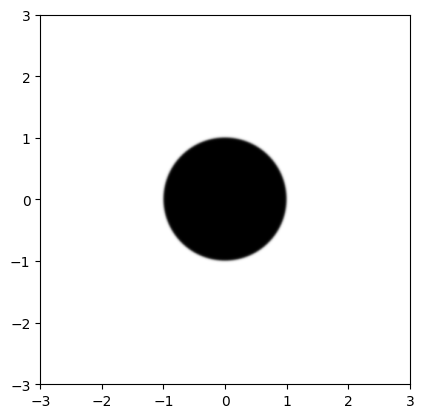

In [222]:
shape = (
    circle(1, (0, -0.5)),
    (0, -0.5)
)
def cost(x):
    cost = alignment_cost(update_position(shape[0], shape[1], x[0], x[1]))
    return cost

res = minimize(jax.jit(cost), jnp.array((0., 0.)), method="BFGS")

print("iterations", res.nit)
print("end position change", res.x)

end_shape = update_position(shape[0], shape[1], res.x[0], res.x[1])
print("final cost", alignment_cost(end_shape))

show_sdf(end_shape, bounds=(-3, 3))

### Trying to apply to a rectangle

In [120]:
rectangle_sdf = translate(rotate(rectangle((1,0.5)), jnp.pi / 3), (0, 0.1))
rectange_center_of_gravity = centroid(rectangle_sdf, bounds=(-5, 5), n=100000)

In [209]:
shape = (
    rectangle_sdf,
    rectange_center_of_gravity
)

def cost(x, y):
    return alignment_cost(update_position(shape[0], shape[1], x, y))

jax.value_and_grad(cost, (0, 1))(jnp.array(0.0), jnp.array(0.0))

(Array(0.13457097, dtype=float32),
 (Array(nan, dtype=float32, weak_type=True),
  Array(nan, dtype=float32, weak_type=True)))

[3.3209505 3.21037   6.3215947 ... 3.7962677 7.3122106 2.6768963]
[-0.00317674  0.99466735]
[4.587959  4.580017  4.572094  ... 3.3272502 3.3376634 3.3480763]


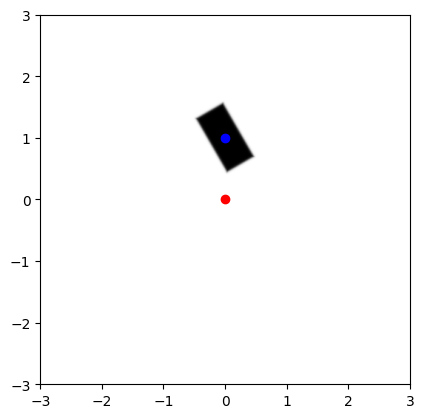

In [99]:
sdf = translate(rotate(rectangle((1,0.5)), jnp.pi / 3), (2., 1.))
#sdf = rotate_around_center(sdf, jnp.pi, (1., 1.))
#sdf = intersection(bottom_half_plane, rectangle_sdf)

center = centroid(sdf, bounds=(-5, 5), n=100000)
print(center)

show_sdf(sdf, (-3, 3))


plt.scatter(0, 0, c="red")
plt.scatter(center[0], center[1], c="blue")


